# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.init as init
import torch.optim as optim


import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

%matplotlib inline

## Device

Set device to work with (GPU or CPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [45]:
valid_size = 0.2
batch_size = 400
num_workers = 0

def get_data_set():



    transform_train = transforms.Compose([
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])


    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])


    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
    test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform_test)

    return train_data, test_data

train_data, test_data = get_data_set()

Files already downloaded and verified
Files already downloaded and verified


In [46]:
def split_data():
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
        sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)
    
    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = split_data()


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

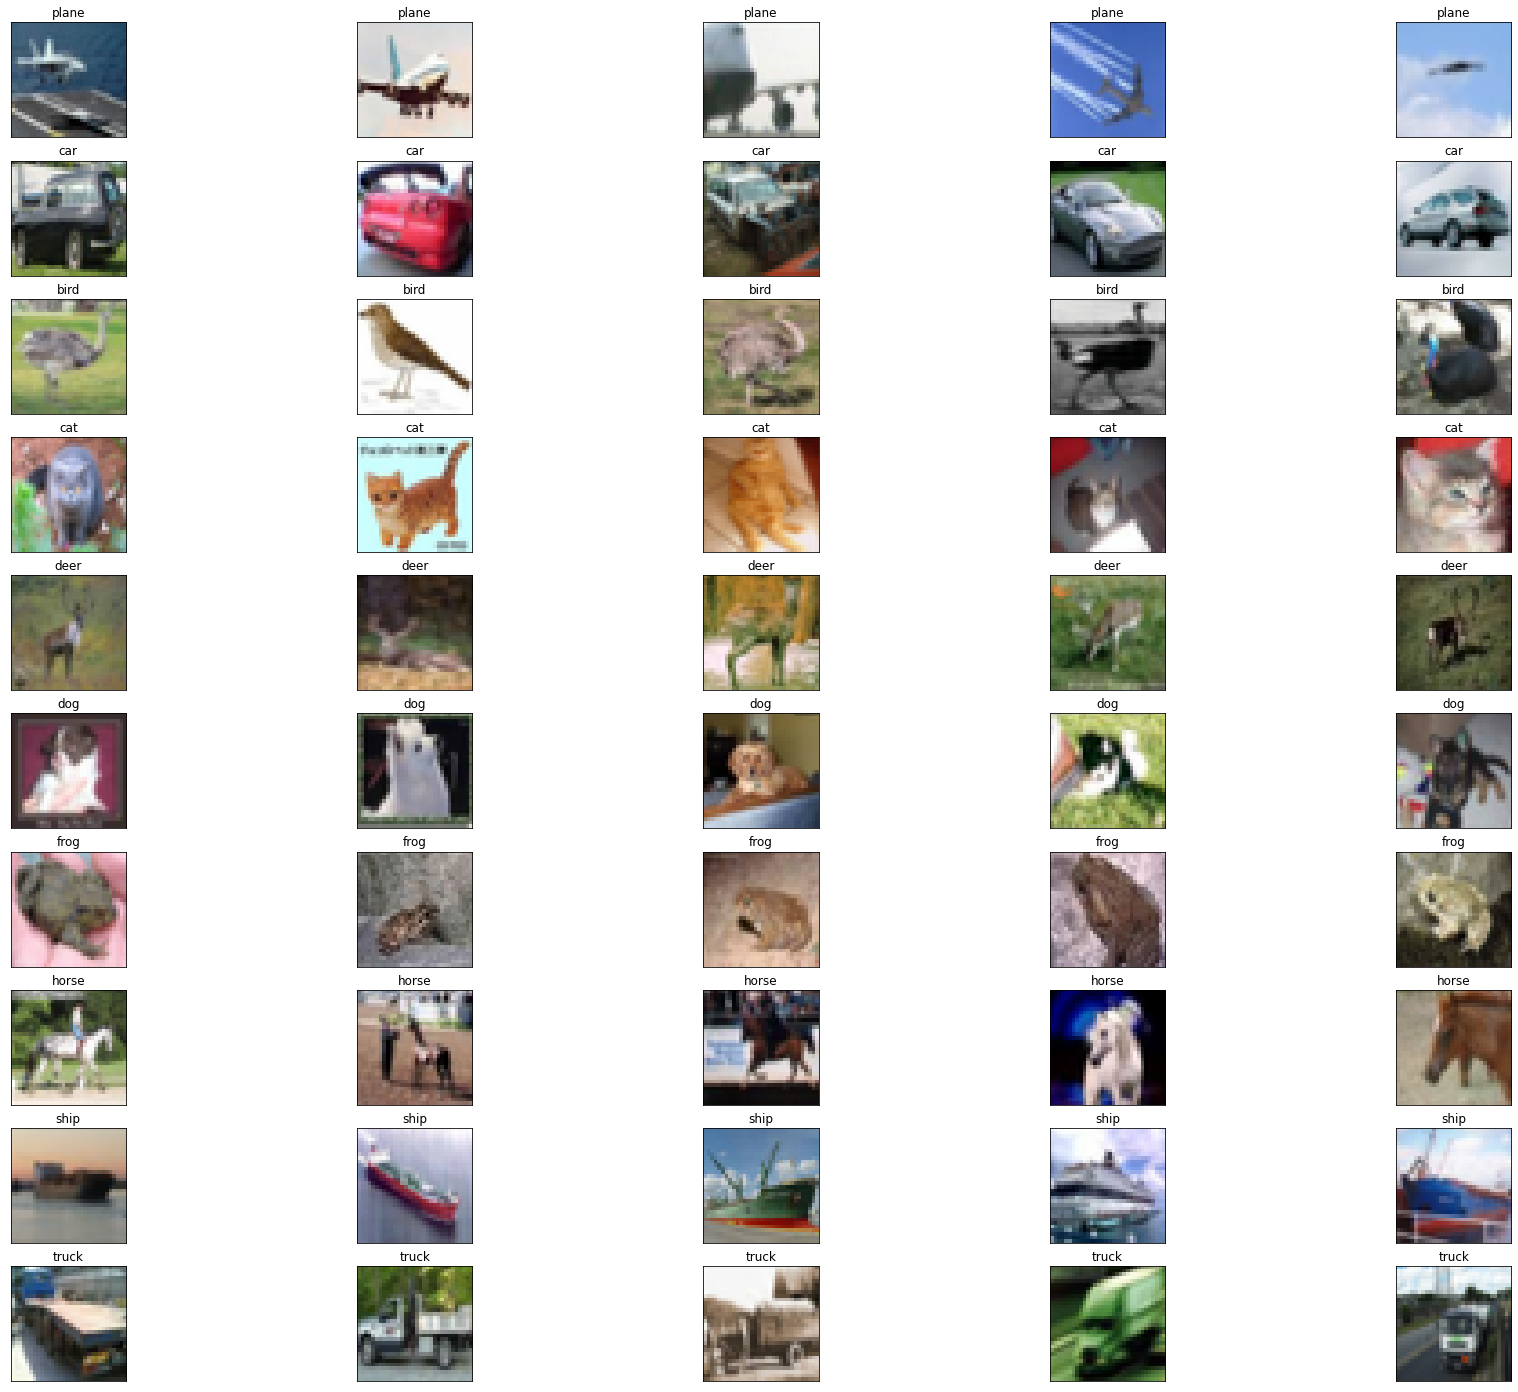

In [47]:

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


images_to_be_shown = {}

for label in classes:
    images_to_be_shown[label] = []

cnt = 0
for idx, img in enumerate(images):
    if len(images_to_be_shown[classes[labels[idx]]]) < 5:
        images_to_be_shown[classes[labels[idx]]].append(img)
        cnt += 1
    if cnt >= 50:
        break


fig = plt.figure(figsize=(30, 25))
# display 50 images
idx = 0
for label in classes:
    for img in images_to_be_shown[label]:
        ax = fig.add_subplot(10, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(((img.T * np.full([32, 32, 3], [0.247, 0.243, 0.261])) + np.array([0.4914, 0.4822, 0.4465]).T).T, (1, 2, 0)))
        ax.set_title(label)
        idx += 1


In [8]:
batch_size = 20
train_data, test_data = get_data_set()
train_loader, valid_loader, test_loader = split_data()

Files already downloaded and verified
Files already downloaded and verified


## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [9]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, 64)
        self.FC = nn.Linear(64, num_classes)
        self.FC.register_forward_hook(self.get_features)

    def get_features(self, module, inputs, outputs):
        self.features = inputs

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion      
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.FC(out)
        return out

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [10]:
ResNet18 = ResNet(BasicBlock, [2,2,2,2])
ResNet18 = ResNet18.to(device)
# ResNet18 = torch.nn.DataParallel(ResNet18)
cudnn.benchmark = True

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [11]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [12]:
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

epoch_start = 0
epoch_end = 0

# @torch.no_grad()

def train():
    
    optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

    valid_loss_min = min(valid_loss_list) if valid_loss_list else np.inf

    for epoch in range(epoch_start, epoch_end+1):
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        valid_correct = 0
        
        ###################
        # train the model #
        ###################
        ResNet18.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = ResNet18(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*data.size(0)

            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))
            for i in range(batch_size):
                label = target.data[i]
                train_correct += correct[i].item()
            
            
        ######################    
        # validate the model #
        ######################
        ResNet18.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = ResNet18(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            for i in range(batch_size):
                label = target.data[i]
                valid_correct += correct[i].item()

        
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        train_accuracy = 100. * train_correct / len(train_loader.sampler)
        valid_accuracy = 100. * valid_correct / len(valid_loader.sampler)

        train_accuracy_list.append(train_accuracy)
        valid_accuracy_list.append(valid_accuracy)
            
        print('Epoch: {}\n\tTraining Loss: {:.6f}  \tValidation Loss: {:.6f}\n\tTraining Accuracy {:.2f}%%  \tValidation Accuracy {:.2f}%%'.format(
            epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
        
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(ResNet18.state_dict(), 'ResNet18.pt')
            valid_loss_min = valid_loss

In [67]:
epoch_start = 1
epoch_end = 10

train()


Epoch: 1
	Training Loss: 1.628320  	Validation Loss: 1.460841
	Training Accuracy 39.75%%  	Validation Accuracy 40.00%%
Validation loss decreased (inf --> 1.460841).  Saving model ...
Epoch: 2
	Training Loss: 1.173422  	Validation Loss: 0.970726
	Training Accuracy 58.19%%  	Validation Accuracy 75.00%%
Validation loss decreased (1.460841 --> 0.970726).  Saving model ...
Epoch: 3
	Training Loss: 0.935609  	Validation Loss: 0.834296
	Training Accuracy 67.12%%  	Validation Accuracy 70.00%%
Validation loss decreased (0.970726 --> 0.834296).  Saving model ...
Epoch: 4
	Training Loss: 0.780719  	Validation Loss: 0.661860
	Training Accuracy 72.70%%  	Validation Accuracy 60.00%%
Validation loss decreased (0.834296 --> 0.661860).  Saving model ...
Epoch: 5
	Training Loss: 0.679737  	Validation Loss: 0.705292
	Training Accuracy 76.61%%  	Validation Accuracy 75.00%%
Epoch: 6
	Training Loss: 0.602126  	Validation Loss: 0.529527
	Training Accuracy 79.37%%  	Validation Accuracy 85.00%%
Validation loss

In [68]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))

epoch_start = 11
epoch_end = 15

learning_rate = 0.01

train()

Epoch: 11
	Training Loss: 0.404226  	Validation Loss: 0.512283
	Training Accuracy 85.93%%  	Validation Accuracy 75.00%%
Epoch: 12
	Training Loss: 0.376764  	Validation Loss: 0.401493
	Training Accuracy 87.15%%  	Validation Accuracy 80.00%%
Validation loss decreased (0.466810 --> 0.401493).  Saving model ...
Epoch: 13
	Training Loss: 0.350885  	Validation Loss: 0.390295
	Training Accuracy 87.84%%  	Validation Accuracy 80.00%%
Validation loss decreased (0.401493 --> 0.390295).  Saving model ...
Epoch: 14
	Training Loss: 0.332596  	Validation Loss: 0.420221
	Training Accuracy 88.41%%  	Validation Accuracy 70.00%%
Epoch: 15
	Training Loss: 0.311922  	Validation Loss: 0.418621
	Training Accuracy 89.12%%  	Validation Accuracy 85.00%%


In [69]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
epoch_start = 16
epoch_end = 20

learning_rate = 0.001

train()

Epoch: 16
	Training Loss: 0.237093  	Validation Loss: 0.303935
	Training Accuracy 91.84%%  	Validation Accuracy 100.00%%
Validation loss decreased (0.390295 --> 0.303935).  Saving model ...
Epoch: 17
	Training Loss: 0.207374  	Validation Loss: 0.293506
	Training Accuracy 93.02%%  	Validation Accuracy 95.00%%
Validation loss decreased (0.303935 --> 0.293506).  Saving model ...
Epoch: 18
	Training Loss: 0.194353  	Validation Loss: 0.298338
	Training Accuracy 93.31%%  	Validation Accuracy 90.00%%
Epoch: 19
	Training Loss: 0.184462  	Validation Loss: 0.288580
	Training Accuracy 93.62%%  	Validation Accuracy 100.00%%
Validation loss decreased (0.293506 --> 0.288580).  Saving model ...
Epoch: 20
	Training Loss: 0.175583  	Validation Loss: 0.292963
	Training Accuracy 93.94%%  	Validation Accuracy 80.00%%


In [74]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
epoch_start = 21
epoch_end = 25

learning_rate = 0.0001

train()

Epoch: 21
	Training Loss: 0.170674  	Validation Loss: 0.289531
	Training Accuracy 94.14%%  	Validation Accuracy 100.00%%
Epoch: 22
	Training Loss: 0.168025  	Validation Loss: 0.285529
	Training Accuracy 94.22%%  	Validation Accuracy 95.00%%
Validation loss decreased (0.288580 --> 0.285529).  Saving model ...
Epoch: 23
	Training Loss: 0.165725  	Validation Loss: 0.289462
	Training Accuracy 94.32%%  	Validation Accuracy 100.00%%
Epoch: 24
	Training Loss: 0.166256  	Validation Loss: 0.286214
	Training Accuracy 94.24%%  	Validation Accuracy 90.00%%
Epoch: 25
	Training Loss: 0.162371  	Validation Loss: 0.288771
	Training Accuracy 94.40%%  	Validation Accuracy 90.00%%


In [77]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
epoch_start = 26
epoch_end = 30

learning_rate = 0.001

train()

Epoch: 26
	Training Loss: 0.174325  	Validation Loss: 0.287318
	Training Accuracy 93.88%%  	Validation Accuracy 90.00%%
Epoch: 27
	Training Loss: 0.167014  	Validation Loss: 0.288579
	Training Accuracy 94.28%%  	Validation Accuracy 90.00%%
Epoch: 28
	Training Loss: 0.160909  	Validation Loss: 0.286638
	Training Accuracy 94.46%%  	Validation Accuracy 95.00%%
Epoch: 29
	Training Loss: 0.150822  	Validation Loss: 0.296180
	Training Accuracy 94.72%%  	Validation Accuracy 90.00%%
Epoch: 30
	Training Loss: 0.143817  	Validation Loss: 0.283676
	Training Accuracy 95.02%%  	Validation Accuracy 95.00%%
Validation loss decreased (0.285529 --> 0.283676).  Saving model ...


In [85]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
epoch_start = 30
epoch_end = 35

learning_rate = 0.01

train()

Epoch: 30
	Training Loss: 0.321213  	Validation Loss: 0.375227
	Training Accuracy 88.84%%  	Validation Accuracy 85.00%%
Epoch: 31
	Training Loss: 0.299982  	Validation Loss: 0.405144
	Training Accuracy 89.64%%  	Validation Accuracy 95.00%%
Epoch: 32
	Training Loss: 0.284519  	Validation Loss: 0.368291
	Training Accuracy 90.11%%  	Validation Accuracy 85.00%%
Epoch: 33
	Training Loss: 0.268523  	Validation Loss: 0.364902
	Training Accuracy 90.61%%  	Validation Accuracy 90.00%%
Epoch: 34
	Training Loss: 0.257455  	Validation Loss: 0.343494
	Training Accuracy 91.00%%  	Validation Accuracy 95.00%%
Epoch: 35
	Training Loss: 0.242222  	Validation Loss: 0.352291
	Training Accuracy 91.67%%  	Validation Accuracy 100.00%%


In [86]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
epoch_start = 36
epoch_end = 40

learning_rate = 0.0001

train()

Epoch: 36
	Training Loss: 0.131412  	Validation Loss: 0.290925
	Training Accuracy 95.47%%  	Validation Accuracy 95.00%%
Epoch: 37
	Training Loss: 0.127665  	Validation Loss: 0.286058
	Training Accuracy 95.56%%  	Validation Accuracy 90.00%%
Epoch: 38
	Training Loss: 0.126873  	Validation Loss: 0.287675
	Training Accuracy 95.60%%  	Validation Accuracy 90.00%%
Epoch: 39
	Training Loss: 0.125630  	Validation Loss: 0.286129
	Training Accuracy 95.56%%  	Validation Accuracy 95.00%%
Epoch: 40
	Training Loss: 0.125156  	Validation Loss: 0.288606
	Training Accuracy 95.59%%  	Validation Accuracy 95.00%%


In [87]:
epoch_start = 41
epoch_end = 45

learning_rate = 0.0001

train()

Epoch: 41
	Training Loss: 0.123234  	Validation Loss: 0.279073
	Training Accuracy 95.74%%  	Validation Accuracy 100.00%%
Validation loss decreased (0.283676 --> 0.279073).  Saving model ...
Epoch: 42
	Training Loss: 0.121172  	Validation Loss: 0.288714
	Training Accuracy 95.78%%  	Validation Accuracy 100.00%%
Epoch: 43
	Training Loss: 0.121071  	Validation Loss: 0.288882
	Training Accuracy 95.77%%  	Validation Accuracy 90.00%%
Epoch: 44
	Training Loss: 0.120586  	Validation Loss: 0.286050
	Training Accuracy 95.83%%  	Validation Accuracy 95.00%%
Epoch: 45
	Training Loss: 0.121483  	Validation Loss: 0.284009
	Training Accuracy 95.78%%  	Validation Accuracy 95.00%%


In [88]:
epoch_start = 41
epoch_end = 45

learning_rate = 0.0001

train()

Epoch: 41
	Training Loss: 0.120078  	Validation Loss: 0.283501
	Training Accuracy 95.92%%  	Validation Accuracy 100.00%%
Epoch: 42
	Training Loss: 0.118398  	Validation Loss: 0.284575
	Training Accuracy 95.94%%  	Validation Accuracy 90.00%%
Epoch: 43
	Training Loss: 0.120763  	Validation Loss: 0.290672
	Training Accuracy 95.85%%  	Validation Accuracy 95.00%%
Epoch: 44
	Training Loss: 0.116442  	Validation Loss: 0.298964
	Training Accuracy 95.96%%  	Validation Accuracy 90.00%%
Epoch: 45
	Training Loss: 0.115800  	Validation Loss: 0.285385
	Training Accuracy 95.91%%  	Validation Accuracy 95.00%%


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

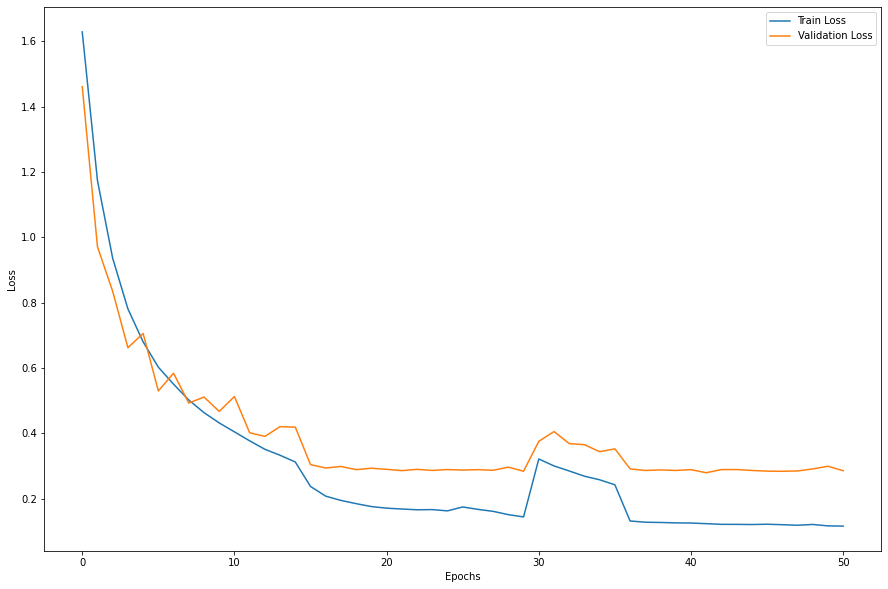

In [89]:
fig = plt.figure(figsize=(15, 10))
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.legend()
plt.show()

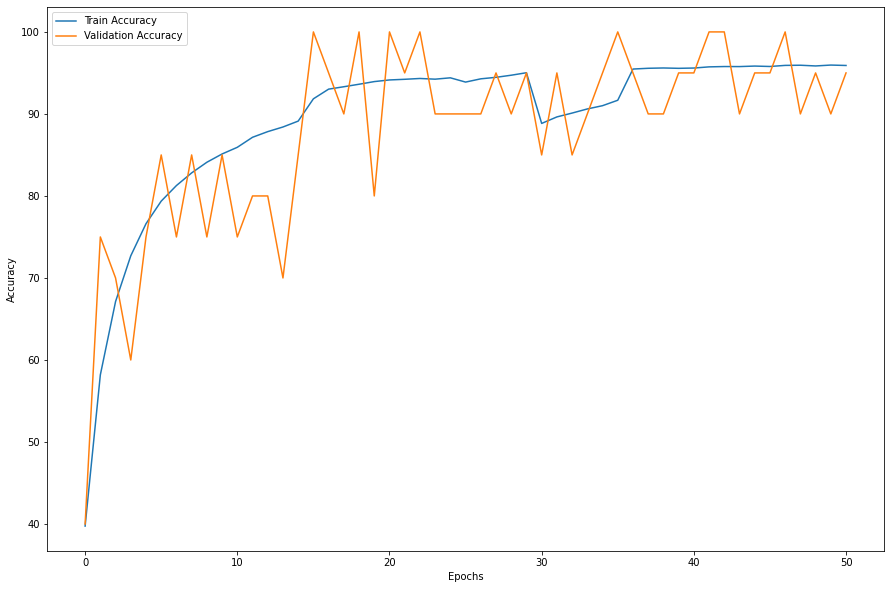

In [90]:
fig.clear()
fig = plt.figure(figsize=(15, 10))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(valid_accuracy_list, label='Validation Accuracy')
plt.legend()
plt.show()

In [53]:
from google.colab import drive
import json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
ResNet18.load_state_dict(torch.load('ResNet18.pt'))
torch.save(ResNet18.state_dict(), "./drive/MyDrive/ResNet18.pt")
log = {'train_loss': train_loss_list, 'valid_loss':valid_loss_list, 'train_accuracy': train_accuracy_list, 'valid_accuracy': valid_accuracy_list}
with open("./drive/MyDrive/log.json", 'w') as logfile:
    json.dump(log, logfile)

In [13]:
# ResNet18.load_state_dict(torch.load('./drive/MyDrive/ResNet18.pt'))
ResNet18.load_state_dict(torch.load('ResNet18.pt'))

<All keys matched successfully>

In [ ]:
f = open("./drive/MyDrive/log.json")

data = json.load(f)
train_loss_list = data['train_loss']
valid_loss_list = data['valid_loss']
train_accuracy_list = data['train_accuracy']
valid_accuracy_list = data['valid_accuracy']

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

incorrect_pred = []


ResNet18.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    
    data, target = data.to(device), target.to(device)
    output = ResNet18(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    

    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))

    incorrect_pred += [(d.cpu().numpy(), p.item(), t.item()) for d, p, t in zip(data[~correct_tensor], pred[~correct_tensor], target[~correct_tensor])]

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

incorrect_pred = np.array(incorrect_pred)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):    
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.315427

Test Accuracy of plane: 91% (918/1000)
Test Accuracy of   car: 95% (954/1000)
Test Accuracy of  bird: 88% (884/1000)
Test Accuracy of   cat: 80% (807/1000)
Test Accuracy of  deer: 92% (924/1000)
Test Accuracy of   dog: 82% (829/1000)
Test Accuracy of  frog: 91% (913/1000)
Test Accuracy of horse: 90% (908/1000)
Test Accuracy of  ship: 96% (960/1000)
Test Accuracy of truck: 94% (943/1000)

Test Accuracy (Overall): 90% (9040/10000)


/tmp/ipykernel_98/3189682597.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  incorrect_pred = np.array(incorrect_pred)


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

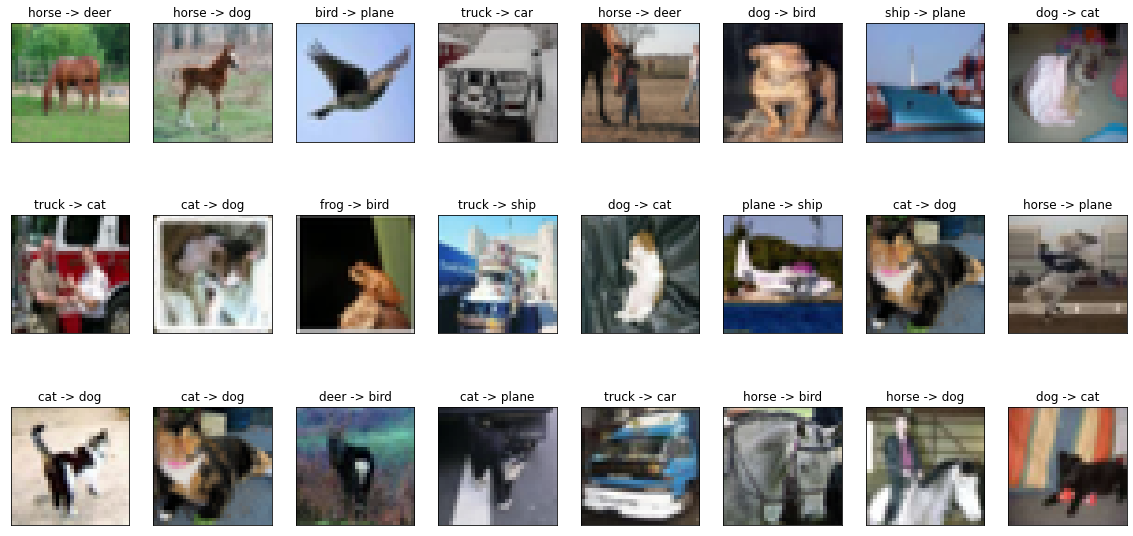

In [37]:
indices = np.random.choice(np.arange(len(incorrect_pred)), 24)

fig = plt.figure(figsize=(20, 10))
idx = 0
for img, pred, target in incorrect_pred[indices]:
    ax = fig.add_subplot(3, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(((img.T * np.full([32, 32, 3], [0.247, 0.243, 0.261])) + np.array([0.4914, 0.4822, 0.4465]).T).T, (1, 2, 0)))    
    ax.set_title(f'{classes[target]} -> {classes[pred]}')
    idx += 1

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [48]:
# ResNet18cpu = ResNet(BasicBlock, [2,2,2,2])
# ResNet18cpu.load_state_dict(torch.load('./drive/MyDrive/ResNet18cpu.pt'))
# ResNet18cpu.load_state_dict(torch.load('ResNet18cpu.pt'))

FC_transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

FC_train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
FC_train_loader = torch.utils.data.DataLoader(FC_train_data, batch_size=100, num_workers=2)

FC_train_data_normalized = datasets.CIFAR10('data', train=True, download=True, transform=FC_transform_train)
FC_train_loader_normalized = torch.utils.data.DataLoader(FC_train_data_normalized, batch_size=100, num_workers=2)


features = []
train_labels = []

features_normalized = []

with torch.no_grad():
    ResNet18.eval()
    for data, labels in FC_train_loader:
        out = ResNet18(data.to(device))
        features.extend(ResNet18.features[0].cpu().numpy())
        train_labels.extend([x.item() for x in labels])
    for data, labels in FC_train_loader_normalized:
        out = ResNet18(data.to(device))
        features_normalized.extend(ResNet18.features[0].cpu().numpy())

Files already downloaded and verified
Files already downloaded and verified


In [49]:
FC = torch.FloatTensor(features)
FC = FC.to(device)
FC.shape

/tmp/ipykernel_98/1867557044.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  FC = torch.FloatTensor(features)


torch.Size([50000, 64])

Feature Space desired in this section is accessible via a hook to the froward pass of ResNet by iterating over data loader and computing it for each batch. We do not store it in another tensor for resource limits.

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [183]:
FC_test_data = datasets.CIFAR10('data', train=False, download=True, transform=FC_transform_train)
knn_test_loader = torch.utils.data.DataLoader(FC_test_data, batch_size=500, num_workers=2, shuffle=True)

dataiter = iter(knn_test_loader)
test_images, labels = dataiter.next()

out = ResNet18(test_images.to(device))
test_features = ResNet18.features[0]

test_images = test_images.numpy()

idxs = np.random.choice(np.arange(500), 5)

test_sample = test_images[idxs]
sample_FC = test_features[idxs].to(device)

sample_FC.shape

Files already downloaded and verified


torch.Size([5, 64])

In [184]:
knn = [None for _ in range(5)]
for i in range(5):
    x = sample_FC[i]
    dist = torch.norm(x - FC, dim=1)
    knn[i] = dist.topk(5, largest=False).indices



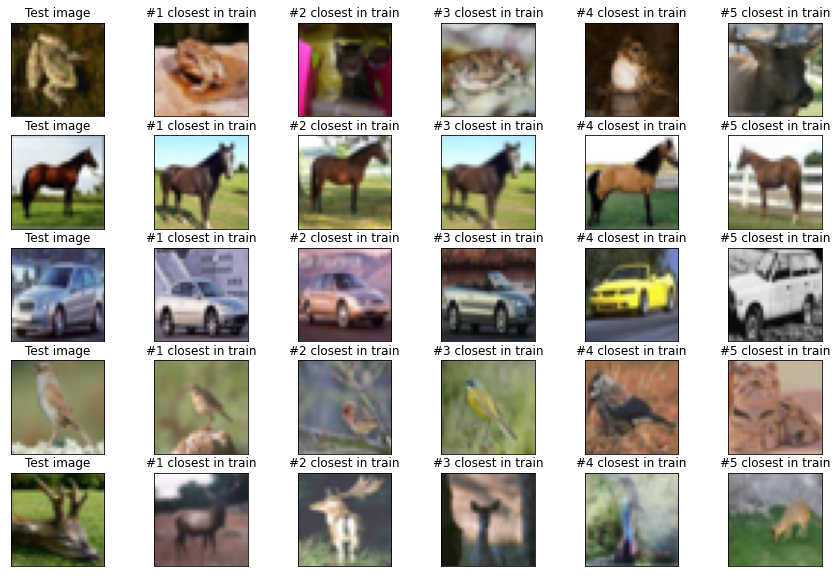

In [185]:
fig = plt.figure(figsize=(15, 10))
idx = 0
for i in range(5):
    ax = fig.add_subplot(5, 6, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(test_sample[i], (1, 2, 0)))
    ax.set_title(f'Test image')
    idx += 1
    for j in range(5):
        ax = fig.add_subplot(5, 6, idx + 1, xticks=[], yticks=[])
        plt.imshow(np.transpose(FC_train_data[knn[i][j]][0].cpu().numpy(), (1, 2, 0)))
        ax.set_title(f'#{j + 1} closest in train')
        idx += 1
    

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [114]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

FC_normalized = torch.FloatTensor(features_normalized)
FC_normalized = FC_normalized.to(device)

sample_indices = np.random.choice(np.arange(50000), 2000)
M = FC_normalized[sample_indices]
M_embedded = TSNE(n_components=2, perplexity=60, n_iter=5000, init='random', learning_rate=10).fit_transform(M.cpu())

M_embedded.shape


(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

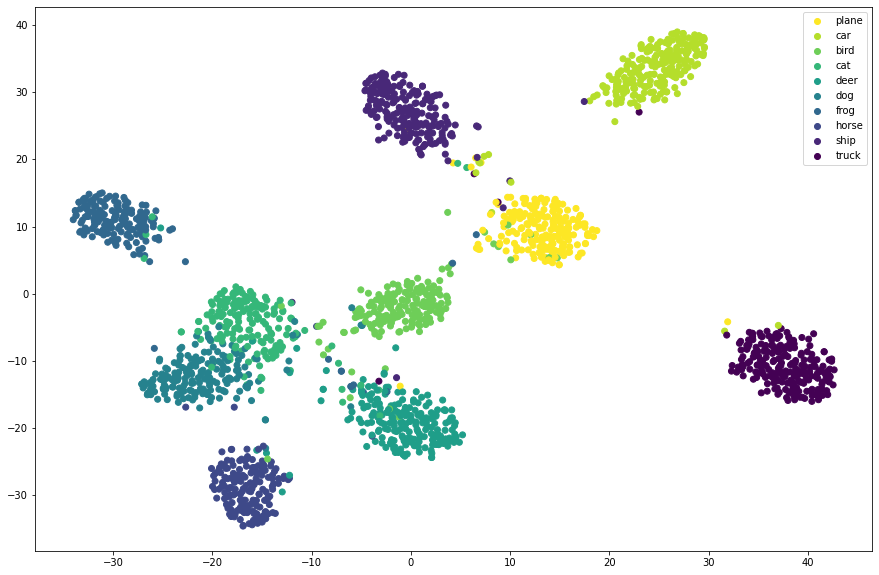

In [115]:
from matplotlib.colors import ListedColormap
import random
    

fig = plt.figure(figsize=(15, 10))

scatter = plt.scatter(M_embedded[:,0], M_embedded[:, 1], c=train_labels[sample_indices], cmap='viridis_r')

plt.legend(handles=scatter.legend_elements()[0], labels=classes)


# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.autograd import Variable
from torch import cat

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
num_epochs = 50
batch_size = 512
learning_rate = 0.001

In [ ]:
class CustomCIFAR10(CIFAR10):

    def __getitem__(self, index):
        rgb_image, label = super().__getitem__(index)
        gray_image = transforms.functional.rgb_to_grayscale(rgb_image, num_output_channels=3)
        
        return rgb_image, gray_image , label



## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_data = CustomCIFAR10('./data', transform=transform_train, train=True, download=True)
test_data = CustomCIFAR10('./data', train=False, download=True, transform=transform_test)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, 
    num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

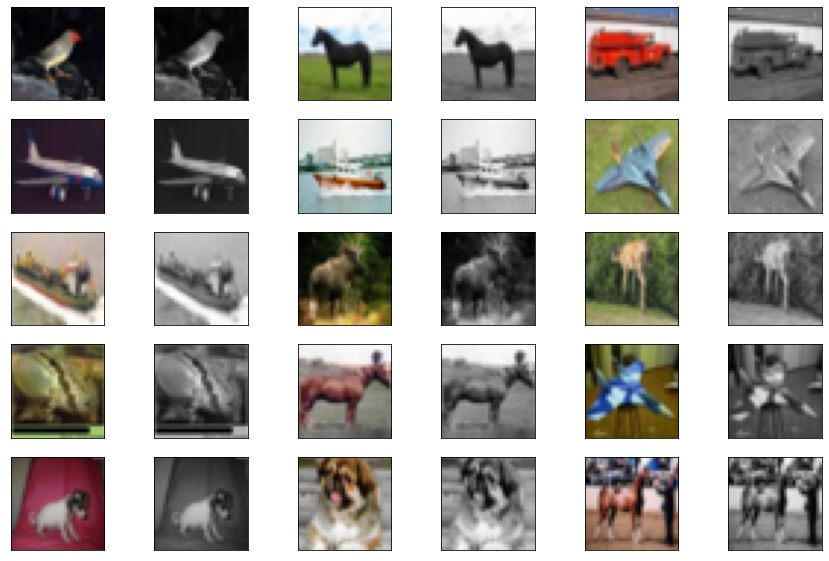

In [ ]:
def imshow(img, is_gray=False):
  # img = img / 2 + 0.5  # unnormalize
    # if is_gray:
    #     plt.imshow(np.transpose(np.dstack([img.T]*3), (1, 0, 2)))
    # else:
    plt.imshow(np.transpose(img, (1, 2, 0))) 




dataiter = iter(train_loader)
RGBs, grays, labels = dataiter.next()
RGBs = RGBs.numpy()
grays = grays.numpy()


fig = plt.figure(figsize=(15, 10))
for idx in range(0, 30, 2):
    ax = fig.add_subplot(5, 6, idx+1, xticks=[], yticks=[])
    imshow(RGBs[idx])
    ax = fig.add_subplot(5, 6, idx+2, xticks=[], yticks=[])
    imshow(grays[idx], True)
         


## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x



In [ ]:
cnet = ColorNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)

In [ ]:
num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 774211


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

train_loss_avg = []
valid_loss_avg = []

for epoch in range(5):
    train_loss_avg.append(0)
    valid_loss_avg.append(0)
    num_batches = 0


    cnet.train()
    for rgb_batch, gray_batch, _ in train_loader:
        
        gray_batch = gray_batch.to(device)
        rgb_batch = rgb_batch.to(device)
        

        predicted_batch = cnet(gray_batch)
        

        loss = F.mse_loss(predicted_batch, rgb_batch)
        

        optimizer.zero_grad()
        loss.backward()
        

        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1


    ######################    
    # validate the model #
    ######################
    v_num_batches = 0
    cnet.eval()
    for batch_idx, (rgb, gray, _) in enumerate(valid_loader):
        gray = gray.to(device)
        rgb = rgb.to(device)
        predicted_batch = cnet(gray)
        loss = F.mse_loss(predicted_batch, rgb)
        valid_loss_avg[-1] += loss.item()
        v_num_batches += 1
        


        
    train_loss_avg[-1] /= num_batches
    valid_loss_avg[-1] /= v_num_batches
    print('Epoch [%d] \tTrain Loss: %f \tValidation Loss: %f' % (epoch+1, train_loss_avg[-1],  valid_loss_avg[-1]))

Epoch [1] 	Train Loss: 0.007200 	Validation Loss: 0.007906
Epoch [2] 	Train Loss: 0.006191 	Validation Loss: 0.008074
Epoch [3] 	Train Loss: 0.006152 	Validation Loss: 0.007947
Epoch [4] 	Train Loss: 0.006064 	Validation Loss: 0.007990
Epoch [5] 	Train Loss: 0.006014 	Validation Loss: 0.008180


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

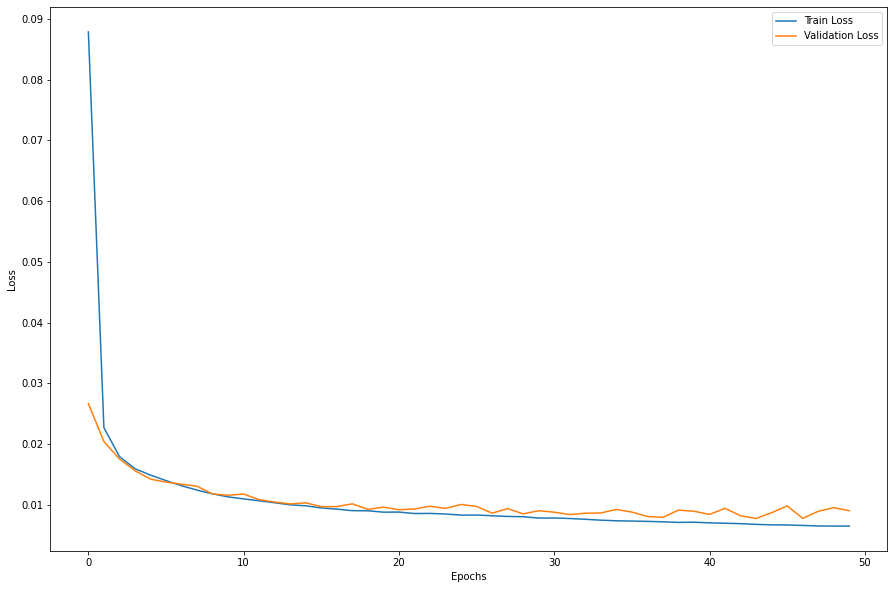

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.plot(train_loss_avg, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(valid_loss_avg, label='Validation Loss')
plt.legend()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



torch.Size([36, 3, 32, 32])


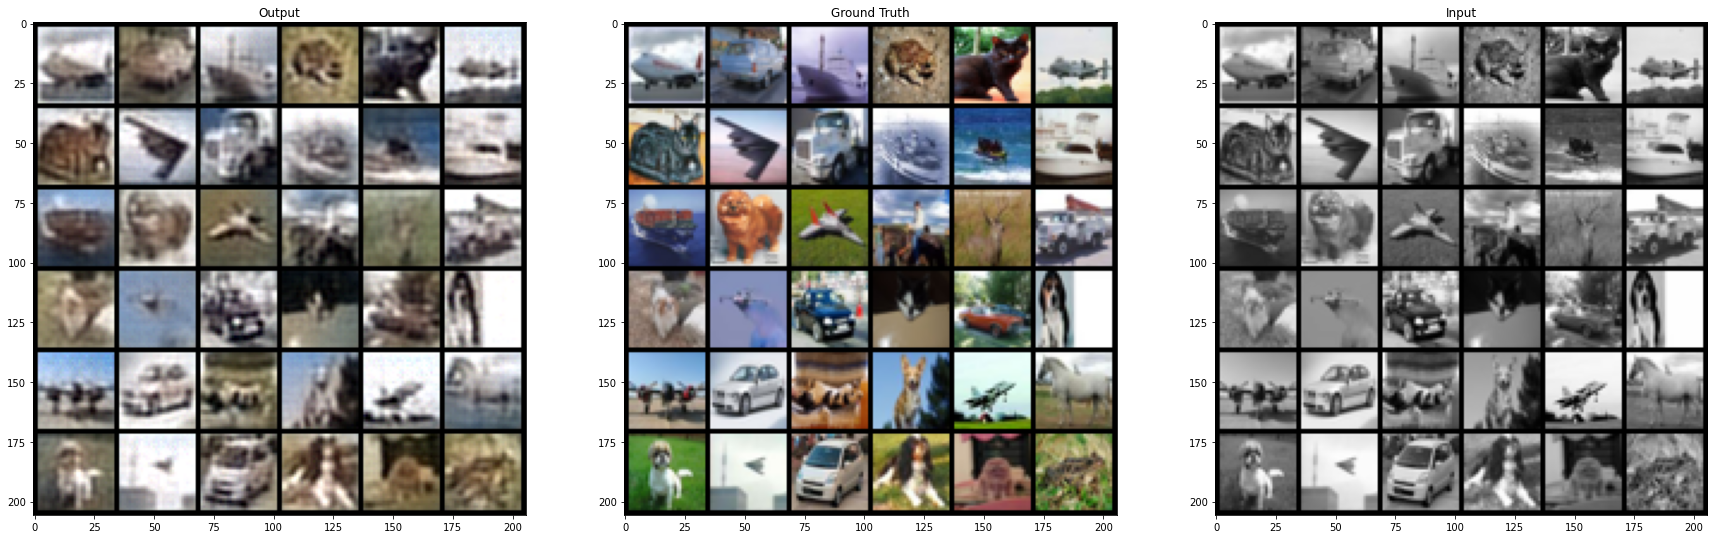

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
from skimage import color

with torch.no_grad():


    image_inds = np.random.choice(len(test_data), 36, replace=False)
    gray_batch = torch.stack([test_data[i][1] for i in image_inds])
    gray_batch = gray_batch.to(device)
    
    predicted_rgb_batch = cnet(gray_batch).cpu()
    print(predicted_rgb_batch.shape)
    gray_batch = gray_batch.cpu()
    


    test_rgb_batch = []
    predicted_rgb_batch_list = []
    for i in range(36):
        rgb_img = np.transpose(test_data[image_inds[i]][0].numpy().astype('float64'), (1, 2, 0))
        test_rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = predicted_rgb_batch[i].numpy().astype('float64')
        predicted_rgb_batch_list.append(torch.FloatTensor(predicted_rgb_img))


    fig, ax = plt.subplots(figsize=(30, 25), nrows=1, ncols=3)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid((gray_batch), nrow=6).numpy(), (1, 2, 0)))
    ax[0].title.set_text('Input')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch_list), nrow=6).numpy(), (1, 2, 0)))
    ax[1].title.set_text('Output')
    ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(test_rgb_batch), nrow=6).numpy(), (1, 2, 0)))
    ax[2].title.set_text('Ground Truth')
    plt.show()
